In [1]:
%load_ext autoreload

In [61]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import datetime
from operator import itemgetter 
import h5py
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

import mintpy
from mintpy import view
from mintpy.utils import readfile, utils as ut 
from mintpy.objects import timeseries
from miaplpy.objects.invert_pixel import process_pixel 
from miaplpy.find_short_baselines import get_baselines_dict

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]



def get_dates_ts(proj_dir, points_lalo, refy, refx, reftype, win_s=5):
    from mintpy.objects import timeseries   
  
    tsStack = proj_dir + '/{}'.format('timeseries_demErr.h5')
    gStack = proj_dir +'/inputs/geometryRadar.h5'
    atr = readfile.read_attribute(tsStack)
    coord = ut.coordinate(atr, gStack)
    stack_obj = timeseries(tsStack)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    ts = np.zeros([len(points_lalo), num_dates])
    
    for t, coord in enumerate(points_lalo):
    
        if reftype == 'lalo':
            dates, ts[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack, lookup_file=gStack, 
                                                      ref_lat=refy, ref_lon=refx, win_size=win_s, unit='cm', 
                                                      print_msg=True)[0:2]
        if reftype =='yx':
            dates, ts[t, :] = ut.read_timeseries_yx(coord[0], coord[1], tsStack, ref_y=refy, ref_x=refx, 
                                                    win_size=win_s, unit='cm', print_msg=True)[0:2]
    
        
    x_values = [date.timetuple().tm_yday for date in dates]
    x = np.zeros([len(x_values),1])
    m = 0
    for t, value in enumerate(x_values):
        x[t] = value
        if t > 0: 
            if value < x[t-1]:
                if value < x_values[t-1]:
                    m += 360
                    x[t] += m
                else:
                    x[t] += m
                
    x = [y - x[0] for y in x]
    return dates, x, ts



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [3]:
def read_ds(proj_dir):
    velocity_file = proj_dir + '/geocoded/geo_velocity.h5'
    mask_file_t = proj_dir + '/geocoded/geo_maskTempCoh.h5'

    velocity = readfile.read(velocity_file, datasetName='velocity')[0]
    mask = np.ones(velocity.shape, dtype=np.int8)    
    mask = readfile.read(mask_file_t, datasetName='mask')[0]
    
    vel = np.array(velocity[mask==1]*100)
    
    return lat, lon, vel

In [19]:
prj_dir = './PichinchaSenDT142'
if not os.path.exists(prj_dir):
    !wget https://zenodo.org/record/6539952/files/PichinchaSenDT142.zip
    !unzip PichinchaSenDT142.zip
    !miaplpyApp.py templates/PichinchaSenDT142_single_reference.txt --dir ./PichinchaSenDT142/miaplpy
    !miaplpyApp.py templates/PichinchaSenDT142_mini_stacks.txt --dir ./PichinchaSenDT142/miaplpy --start generate_ifgram
    !miaplpyApp.py templates/PichinchaSenDT142_Delaunay.txt --dir ./PichinchaSenDT142/miaplpy --start generate_ifgram
    !miaplpyApp.py templates/PichinchaSenDT142_sequential_1.txt --dir ./PichinchaSenDT142/miaplpy --start generate_ifgram
    !miaplpyApp.py templates/PichinchaSenDT142_sequential_3.txt --dir ./PichinchaSenDT142/miaplpy --start generate_ifgram
    !miaplpyApp.py templates/PichinchaSenDT142_sequential_8.txt --dir ./PichinchaSenDT142/miaplpy --start generate_ifgram
    
  

--------------------------------------------------

_________________________________________________      

  /##      /## /##                     / ## /#######
 | ###    /###|__/|                    | ##| ##__  ##
 | ####  /#### /##|/ ##### /##         | ##| ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ### /####### | ##| #######/| ##  | ##
 | ##  ###| ##| ##| ##__  ###| ##__  ##| ##| ##      | ##  | ##
 | ##\  # | ##| ##| ##   \###| ##   \##| ##| ##      | ##  | ##
 | ## \/  | ##| ##|  ##### ##| #######/| ##| ##      |  #######
 |__/     |__/|__/| \____/|_/| ##____/ |__/|__/       \____  ##
                             | ##                     /##  | ## 
                             | ##                    |  ######/         
                             |__/                     \______/
 Miami Non-Linear Phase Linking software in Python   
          MiaplPy 0.2.0, 2021-09-14
_________________________________________________

--RUN-at-2022-11-13 08:58:11.479676--
Current directory: /

['/Users/saramirzaee/soft/rsmas_insar/3rdparty/miniconda3/bin/smallbaselineApp.py', '/Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/templates/PichinchaSenDT142_Delaunay.txt', '--start', 'modify_network', '--stop', 'correct_unwrap_error', '--dir', '/Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4']

___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                

input reference point in lat/lon: (-0.1786, -78.5933)
input reference point in y/x: (327, 525)
mask: maskConnComp.h5
--------------------------------------------------
calculate the temporal average of unwrapPhase in file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/inputs/ifgramStack.h5 ...
[==================================================] lines 530/530 
Add/update ref_x/y attribute to file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/inputs/ifgramStack.h5
{'REF_Y': '327', 'REF_X': '525'}
touch avgSpatialCoh.h5
touch maskConnComp.h5


******************** step - quick_overview ********************

temporal_average.py /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/inputs/ifgramStack.h5 --dataset unwrapPhase -o /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenD

close  HDF5 file: numInvIfgram.h5


------- start parallel processing using Dask -------
input Dask cluster type: local
initiate Dask cluster
split patch into 8 sub boxes in x direction for workers to process
scale Dask cluster to 8 workers
initiate Dask client
submit a job to the worker for sub box 0: [0, 0, 211, 530]
submit a job to the worker for sub box 1: [211, 0, 422, 530]
submit a job to the worker for sub box 2: [422, 0, 633, 530]
submit a job to the worker for sub box 3: [633, 0, 844, 530]
submit a job to the worker for sub box 4: [844, 0, 1055, 530]
submit a job to the worker for sub box 5: [1055, 0, 1266, 530]
submit a job to the worker for sub box 6: [1266, 0, 1477, 530]
submit a job to the worker for sub box 7: [1477, 0, 1685, 530]
calculating weight from spatial coherence ...
reading coherence in [0, 0, 211, 530] * 112 ...
calculating weight from spatial coherence ...
reading coherence in [633, 0, 844, 530] * 112 ...
calculating weight from spatial coherence ...
calculati

close dask client
close dask cluster
------- finished parallel processing -------


--------------------------------------------------
open  HDF5 file timeseries.h5 in a mode
writing dataset /timeseries                block: [0, 46, 0, 530, 0, 1685]
close HDF5 file timeseries.h5.
--------------------------------------------------
open  HDF5 file temporalCoherence.h5 in a mode
writing dataset /temporalCoherence         block: [0, 530, 0, 1685]
close HDF5 file temporalCoherence.h5.
--------------------------------------------------
open  HDF5 file numInvIfgram.h5 in a mode
writing dataset /mask                      block: [0, 530, 0, 1685]
close HDF5 file numInvIfgram.h5.
--------------------------------------------------
update values on the reference pixel: (327, 525)
set temporalCoherence on the reference pixel to 1.
set  # of observations on the reference pixel as 112
roll back to the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THR

close  HDF5 file: demErr.h5
--------------------------------------------------
grab dataset structure from ref_file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/timeseries.h5
create HDF5 file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/timeseries_demErr.h5 with w mode
create dataset  : bperp      of float32                   in size of (46,)                with compression = None
create dataset  : date       of |S8                       in size of (46,)                with compression = None
create dataset  : timeseries of float32                   in size of (46, 530, 1685)      with compression = None
close  HDF5 file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/timeseries_demErr.h5
--------------------------------------------------
grab dataset structure from ref_file: /Users/saramirz

close HDF5 file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/timeseriesResidual.h5.
roll back to the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
remove env variable OMP_NUM_THREADS
remove env variable OPENBLAS_NUM_THREADS
remove env variable MKL_NUM_THREADS
remove env variable NUMEXPR_NUM_THREADS
remove env variable VECLIB_MAXIMUM_THREADS
time used: 00 mins 34.2 secs.


******************** step - residual_RMS ********************

timeseries_rms.py timeseriesResidual.h5 -t /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/smallbaselineApp.cfg
read options from template file: smallbaselineApp.cfg
remove quadratic ramp from file: timeseriesResidual.h5
read mask file: maskTempCoh.h5
--------------------------------------------------
grab metadata from ref_file: timeseriesResi

skip pixels with zero/nan value in all acquisitions
number of pixels to invert: 882000 out of 893050 (98.8%)
estimating time functions via linalg.lstsq ...
estimating time functions STD from time-series fitting residual ...
--------------------------------------------------
open  HDF5 file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/velocity.h5 in a mode
writing dataset /intercept                 block: [0, 530, 0, 1685]
close HDF5 file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/velocity.h5.
--------------------------------------------------
open  HDF5 file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/velocity.h5 in a mode
writing dataset /interceptStd              block: [0, 530, 0, 1685]
close HDF5 file /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/

update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: temporalCoherence.h5
create HDF5 file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_temporalCoherence.h5 with w mode
create dataset  : temporalCoherence of float32                   in size of (1760, 600)          with compression = None
close  HDF5 file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_temporalCoherence.h5
--------------------------------------------------1/1
reading temporalCoherence in block (0, 0, 1685, 530) from temporalCoherence.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 2 segments ...
write data in block [0, 1760, 0, 600] to file: /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_temporalCoherence.h5
---------------

data   coverage in y/x: (0, 0, 600, 1760)
subset coverage in y/x: (0, 0, 600, 1760)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/600/1760
update Y/X_FIRST
update REF_Y/X
read mask from file: geo_maskTempCoh.h5
masking out pixels with zero value in file: None
colormap: jet
plotting data ...
figure size : [12.00, 15.63]
show reference point
writing /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_velocity.png with dpi=600
writing /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_velocity_cbar.png
writing /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_velocity.kml
remove /Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi/PichinchaSenDT142/miaplpy/network_delaunay_4/geo/geo_velocity.kml
remove /Users/saramirzaee/Documents/2022_MiaplPy_Mirzae

In [66]:
points_lalo = np.array([(-0.1703, -78.6120), 
                        (-0.1793, -78.5960),
                        (-0.1550, -78.6042)]) 

points_lalo = np.array([(-0.1703, -78.6120), 
                        (-0.1793, -78.5960)]) 

points_lalo = np.array([(-0.1562, -78.6056), 
                        (-0.1793, -78.5960)]) 

reflat, reflon = -0.1785, -78.5933


project_dirs = [prj_dir + '/miaplpy/network_single_reference',
                prj_dir + '/miaplpy/network_delaunay_4',
                prj_dir + '/miaplpy/network_mini_stacks',
                prj_dir + '/miaplpy/network_sequential_1',
                prj_dir + '/miaplpy/network_sequential_3',
                prj_dir + '/miaplpy/network_sequential_8']

data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]


geom_file = prj_dir + '/inputs/geometryRadar.h5'

bbox = '-0.1963 -0.1500 -78.6230 -78.5869'   # attr_b['mintpy.subset.lalo'].split(',')
lat = [float(i) for i in bbox.split()[0:2]]
lon = [float(i) for i in bbox.split()[2::]]

baselines, dates = get_baselines_dict(prj_dir + '/miaplpy/inputs/baselines')
out_dir = './out_figures'

In [67]:
refx = 441
refy = 334
# referencing
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    geom_file = prj + '/inputs/geometryRadar.h5'
    !reference_point.py $velfile -l $reflat -L $reflon --lookup $geom_file
    !reference_point.py $velfile -x $refx -y $refy --lookup $geom_file

--------------------------------------------------
input reference point in lat/lon: (-0.1785, -78.5933)
input reference point in y/x: (327, 526)
--------------------------------------------------
updating dataset values without re-writing to a new file
update metadata
--------------------------------------------------
input reference point in y/x: (334, 441)
--------------------------------------------------
updating dataset values without re-writing to a new file
update metadata
--------------------------------------------------
input reference point in lat/lon: (-0.1785, -78.5933)
input reference point in y/x: (327, 526)
--------------------------------------------------
updating dataset values without re-writing to a new file
update metadata
--------------------------------------------------
input reference point in y/x: (334, 441)
--------------------------------------------------
updating dataset values without re-writing to a new file
update metadata
----------------------------

In [48]:
geom_file

'./PichinchaSenDT142/inputs/geometryRadar.h5'

In [68]:
## geocodeing


for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    geom_file = prj +'/inputs/geometryRadar.h5'
    !mask.py $prj_dir/miaplpy/inverted/tempCoh_average -m $prj_dir/miaplpy/shadow_mask.h5 -o $temp_coh
    geocode_dir = prj + '/geocoded'
    os.makedirs(geocode_dir, exist_ok=True)
    !geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .55 -o $geocode_dir/geo_maskTempCoh.h5

masking band1 from ./PichinchaSenDT142/miaplpy/inverted/tempCoh_average ...
delete exsited file: ./PichinchaSenDT142/miaplpy/network_single_reference/temporalCoherence.h5
create HDF5 file: ./PichinchaSenDT142/miaplpy/network_single_reference/temporalCoherence.h5 with w mode
create dataset /band1 of float32    in size of (530, 1685)          with compression=None
finished writing to ./PichinchaSenDT142/miaplpy/network_single_reference/temporalCoherence.h5
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: ./PichinchaSenDT142/miaplpy/network_single_reference/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (-0.20817254467823032, -0.1331726196782303, -78.62402447726562, -78.56643194226562)
output file row / column number: (405, 311)
--------------------------------------------------
resampling file: ./PichinchaSenDT142/miaplpy/network

nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading intercept    in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading interceptStd in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading residue      in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tr

input tempCoh_average file: ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_temporalCoherence.h5
read ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.55
delete exsited file: ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_maskTempCoh.h5
create HDF5 file: ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (405, 311)           with compression=None
finished writing to ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_maskTempCoh.h5
time used: 00 mins 0.0 secs.
masking band1 from ./PichinchaSenDT142/miaplpy/inverted/tempCoh_average ...
delete exsited file: ./PichinchaSenDT142/miaplpy/network_sequential_1/temporalCoherence.h5
create HDF5 file: ./PichinchaSenDT142/miaplpy/network_sequential_1/temporalCoherence.h5

close  HDF5 file: ./PichinchaSenDT142/miaplpy/network_sequential_3/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading velocity     in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_sequential_3/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading velocityStd  in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_sequential_3/geocoded/geo_velocity.h5
--------------------------------------------------1/1
reading intercept    in block (0, 0, 1685, 530) from velocity.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT

write data in block [0, 405, 0, 311] to file: ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_temporalCoherence.h5
time used: 00 mins 0.4 secs.

input tempCoh_average file: ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_temporalCoherence.h5
read ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.55
delete exsited file: ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_maskTempCoh.h5
create HDF5 file: ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (405, 311)           with compression=None
finished writing to ./PichinchaSenDT142/miaplpy/network_sequential_8/geocoded/geo_maskTempCoh.h5
time used: 00 mins 0.0 secs.


In [69]:
velfile_sr = project_dirs[0] + '/geocoded/geo_velocity.h5'
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se1_sr.h5', 'diff_vel_se3_sr.h5', 'diff_vel_se8_sr.h5']
i = 0
for prj in project_dirs[1::]:
    velfile = prj + '/geocoded/geo_velocity.h5'
    out_file = geocode_dir + out_files[i]
    !diff.py $velfile $velfile_sr -o $out_file
    i += 1

./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5 - ['./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/geo_velocity.h5'] --> ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_de_sr.h5
the 1st input file is: velocity
List of common datasets across files:  ['residue', 'velocity', 'intercept', 'velocityStd', 'interceptStd']
differencing residue ...
differencing velocity ...
differencing intercept ...
differencing velocityStd ...
differencing interceptStd ...
use metadata from the 1st file: ./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5
delete exsited file: ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_de_sr.h5
create HDF5 file: ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_de_sr.h5 with w mode
create dataset /residue      of float32    in size of (405, 311)           with compression=None
create dataset /velocity     of float32    in size of (405, 311)        

In [70]:
vel_sr = read_ds(project_dirs[0])[2]
vel_de = read_ds(project_dirs[1])[2]
vel_mi = read_ds(project_dirs[2])[2]
vel_se1 = read_ds(project_dirs[3])[2]
vel_se3 = read_ds(project_dirs[4])[2]
vel_se8 = read_ds(project_dirs[5])[2]

In [71]:
diff_sr_de = vel_de - vel_sr
diff_sr_mi = vel_mi - vel_sr
diff_sr_se1 = vel_se1 - vel_sr
diff_sr_se3 = vel_se3 - vel_sr
diff_sr_se8 = vel_se8 - vel_sr

print('delaunay rmse:', np.sqrt(np.sum(diff_sr_de.flatten()**2)/(len(diff_sr_de.flatten())-1)))
print('ministacks rmse:', np.sqrt(np.sum(diff_sr_mi.flatten()**2)/(len(diff_sr_mi.flatten())-1)))
print('sequential 1 rmse:', np.sqrt(np.sum(diff_sr_se1.flatten()**2)/(len(diff_sr_se1.flatten())-1)))
print('sequential 3 rmse:', np.sqrt(np.sum(diff_sr_se3.flatten()**2)/(len(diff_sr_se3.flatten())-1)))
print('sequential 8 rmse:', np.sqrt(np.sum(diff_sr_se8.flatten()**2)/(len(diff_sr_se8.flatten())-1)))



delaunay rmse: 0.12963855899614904
ministacks rmse: 0.20139654987009112
sequential 1 rmse: 1.1120445787652986
sequential 3 rmse: 0.2788585025858695
sequential 8 rmse: 0.16218634232284437


view.py ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py ./PichinchaSenDT142/miaplpy/network_delaunay_4/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py ./PichinchaSenDT142/miaplpy/network_mini_stacks/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wr

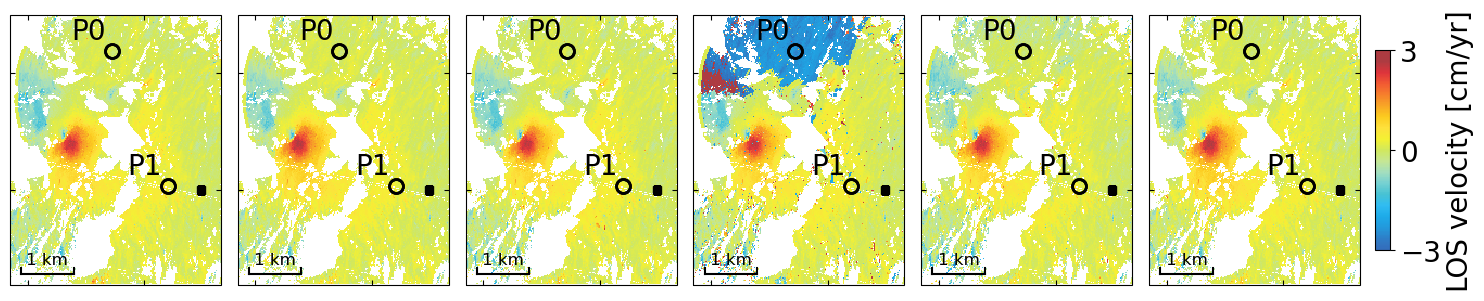

In [72]:

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "20"

#titiles = ['Single reference','Mini stacks', 'Delaunay', 'Redundant sequential', 'Non-redundant Sequential']


fsize = 12

#dem_file = os.path.expanduser('/Users/Sara/Documents/insarlab/scratch/Ecuador/DEM/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 12 --nocbar --alpha 0.9 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 '
opt += ' --noverbose  --notitle '

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(6):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' --wrap --wrap-range -{f} {f} '.format(f=3)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

    for x in range(points_lalo.shape[0]):
       
        ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, 'P{}'.format(x), fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        ax.set_title('')
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-3,0,3], label='LOS velocity [cm/yr]')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      

out_file = os.path.abspath(out_dir + '/velocity_pichincha_6.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

view.py ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_de_sr.h5 velocity -m ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_mi_sr.h5 velocity -m ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py ./PichinchaSenDT142/miaplpy/network_single_reference/geocoded/diff_vel_se1_sr.h5 velocity -m ./PichinchaSenDT142/miaplpy/network_sin

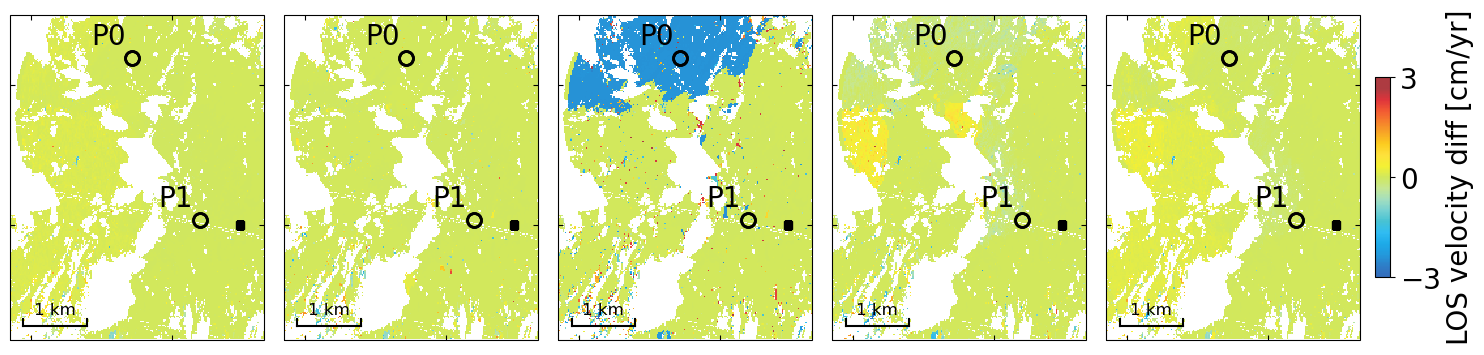

In [73]:
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se1_sr.h5', 'diff_vel_se3_sr.h5', 'diff_vel_se8_sr.h5']
data = [geocode_dir + x for x in out_files]
mask_f = geocode_dir + 'geo_maskTempCoh.h5'

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "20"

#titiles = ['Single reference','Mini stacks', 'Delaunay', 'Redundant sequential', 'Non-redundant Sequential']


fsize = 12

#dem_file = os.path.expanduser('/Users/Sara/Documents/insarlab/scratch/Ecuador/DEM/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 12 --nocbar --alpha 0.9 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 '
opt += ' --noverbose  --notitle '

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(5):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity -m {}'.format(data[t], mask_f) + opt 
    cmd += ' --wrap --wrap-range -{f} {f} '.format(f=3)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

    for x in range(points_lalo.shape[0]):
       
        ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, 'P{}'.format(x), fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        ax.set_title('')
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-3,0,3], label='LOS velocity diff [cm/yr]')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      

out_file = os.path.abspath(out_dir + '/velocity_pichincha_5_diff.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [74]:
reflat, reflon = -0.1675, -78.5967

dates_sr, x_sr, ts_sr = get_dates_ts(project_dirs[0], points_lalo, reflat, reflon, 'lalo')  # single reference
dates_de, x_de, ts_de = get_dates_ts(project_dirs[1], points_lalo, reflat, reflon, 'lalo')  # delaunay
dates_ms, x_ms, ts_ms = get_dates_ts(project_dirs[2], points_lalo, reflat, reflon, 'lalo')  # mini stacks
dates_se1, x_se1, ts_se1 = get_dates_ts(project_dirs[3], points_lalo, reflat, reflon, 'lalo')  # sequential
dates_se3, x_se3, ts_se3 = get_dates_ts(project_dirs[4], points_lalo, reflat, reflon, 'lalo')  # sequential
dates_se8, x_se8, ts_se8 = get_dates_ts(project_dirs[5], points_lalo, reflat, reflon, 'lalo')  # sequential

for i, date in enumerate(dates):
    if datetime.datetime.strptime(date, '%Y%m%d') not in dates_sr:
        del dates[i]

input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1139
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587


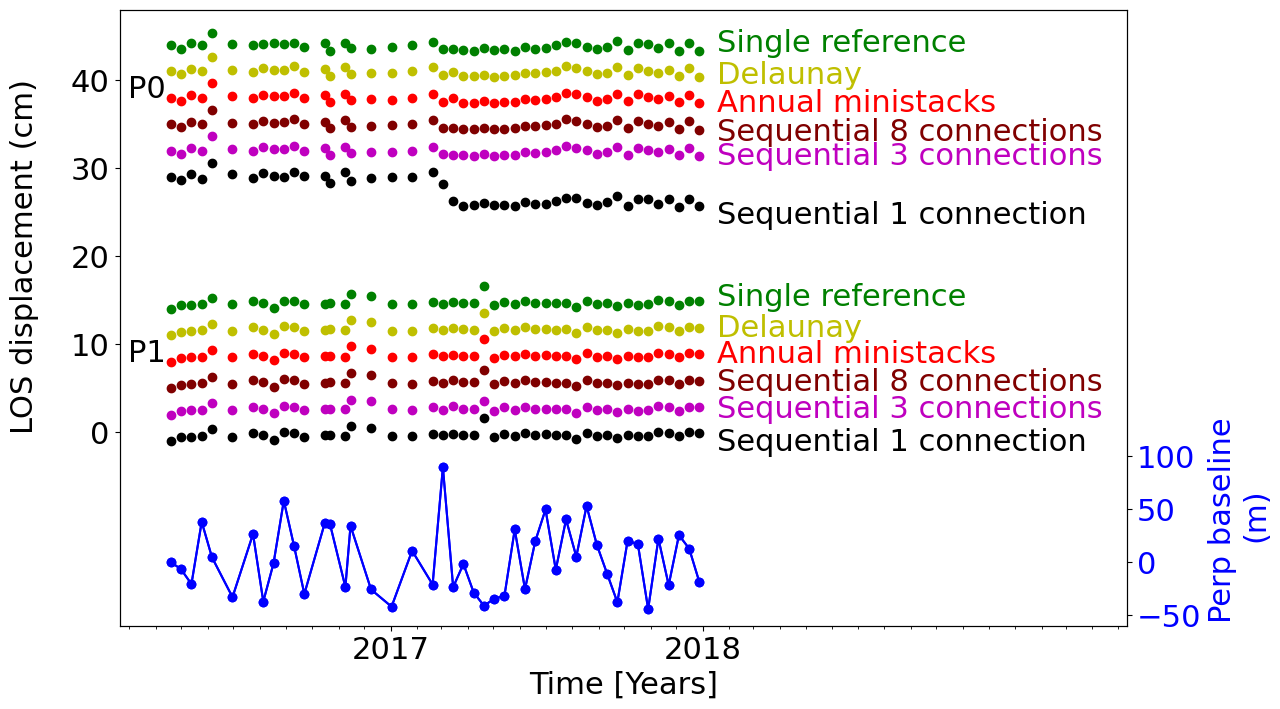

In [75]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [14,11,8,5,2, -1]
lsh = np.array([[13.8,10.2,7,3.8,1.0, -3],
                [13.5,10.0,7,3.9,.8, -3]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [30.0, 0]

labels = ['Single reference', 'Delaunay','Annual ministacks','Sequential 3 connections',
          'Sequential 8 connections', 'Sequential 1 connection']

ax1 = axs
ax2 = ax1.twinx()

bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo)):
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + shifts[0] + shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + shifts[1] + shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + shifts[2] + shift[t], 'ro',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se8, ts_se8[t, :] - ts_se8[t, 0] + shifts[3]+ shift[t], 'o',markersize=6,  linewidth=1, color='maroon')

    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] + shifts[4]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se1, ts_se1[t, :] - ts_se1[t, 0] + shifts[5]+ shift[t], 'ko',markersize=6,  linewidth=1)
    
    ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    ax1.text(dates_ms[-1] + datetime.timedelta(days=20), 
             ts_ms[t, -1] - ts_ms[t, 0] + lsh[t,0]+ shift[t], 
             labels[0], color='g')
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[1], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[2], color='r')
    
    ax1.text(dates_se8[-1] + datetime.timedelta(days=20), 
             ts_se8[t, -1] - ts_se8[t, 0] + lsh[t,3]+ shift[t], 
             labels[4], color='maroon')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,4]+ shift[t], 
             labels[3], color='m')
    
    ax1.text(dates_se1[-1] + datetime.timedelta(days=20), 
             ts_se1[t, -1] - ts_se1[t, 0] + lsh[t,5]+ shift[t], 
             labels[5], color='k')
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=60), dates_se3[-1]+datetime.timedelta(days=500))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

ax2.set_ylim(-60, 520)
ax1.set_ylim(-22.0, 48.0)
ax2.set_ylabel('Perp baseline \n(m)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement (cm)')

ax1.set_xlabel('Time [Years]')

ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 10, 20, 30, 40))
ax1.yaxis.set_label_coords(-0.08, 0.6)
ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0)))
#plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare6.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


In [76]:
ts_sr.shape, ts_de.shape, ts_ms.shape, ts_se3.shape, ts_se1.shape, ts_se8.shape

((2, 46), (2, 46), (2, 46), (2, 46), (2, 46), (2, 46))

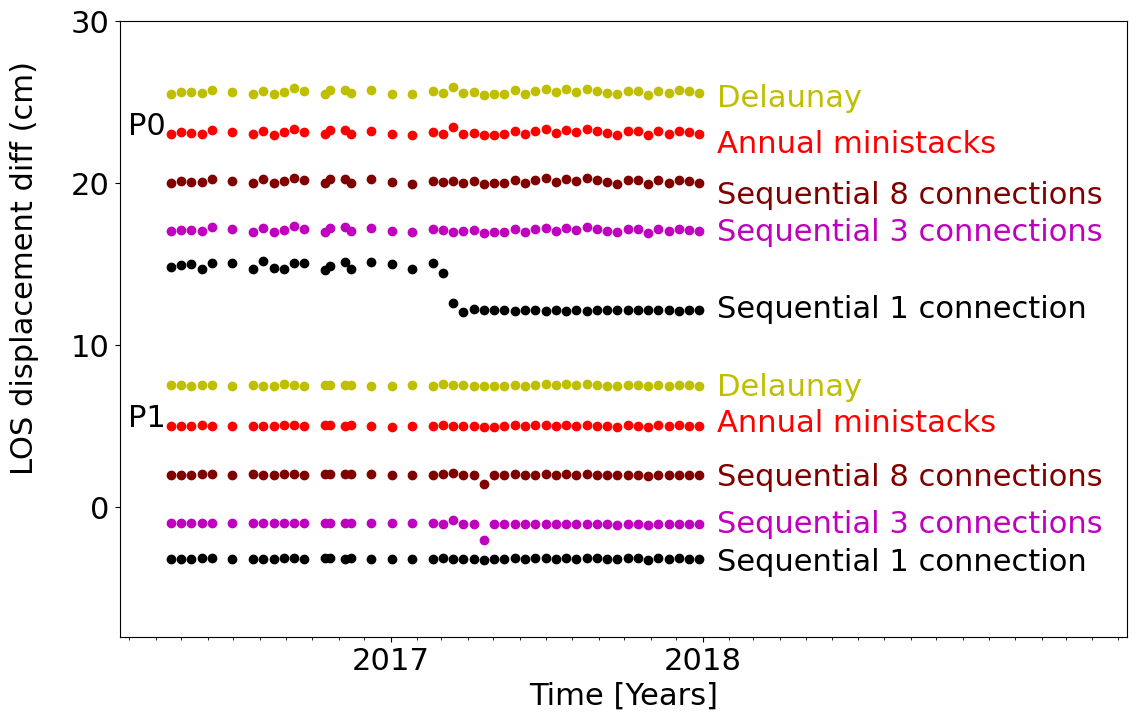

In [77]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [2,7.5,5,2,-1, -3.2]
lsh = np.array([[2,7.4,4.5,1.4,-0.9, -3],
                [2,6,3.8,0.5,-2.4, -4.8]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [18.0, 0]

labels = ['Delaunay','Annual ministacks','Redundant sequential',
          'Non-redundant sequential']
labels = ['Delaunay','Annual ministacks','Sequential 3 connections',
          'Sequential 8 connections', 'Sequential 1 connection']

ax1 = axs
#ax2 = ax1.twinx()

bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo)):
    srts = ts_sr[t, :] - ts_sr[t, 0]
        
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] - srts + shifts[1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] - srts + shifts[2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    ax1.plot(dates_se8, ts_se8[t, :] - ts_se8[t, 0] - srts + shifts[3]+ shift[t], 'o',markersize=6,  linewidth=1, color='maroon')
    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] - srts + shifts[4]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se1, ts_se1[t, :] - ts_se1[t, 0] - srts + shifts[5]+ shift[t], 'ko',markersize=6,  linewidth=1)
    
    #ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[0], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[1], color='r')
    
    ax1.text(dates_se8[-1] + datetime.timedelta(days=20), 
             ts_se8[t, -1] - ts_se8[t, 0] + lsh[t,3]+ shift[t], 
             labels[3], color='maroon')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,4]+ shift[t], 
             labels[2], color='m')
    
    ax1.text(dates_se1[-1] + datetime.timedelta(days=20), 
             ts_se1[t, -1] - ts_se1[t, 0] + lsh[t,5]+ shift[t], 
             labels[4], color='k')
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=60), dates_se3[-1]+datetime.timedelta(days=500))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

#ax2.set_ylim(-60, 520)
ax1.set_ylim(-8, 28)
#ax2.set_ylabel('Perp baseline \n(m)', color='blue')
#ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement diff (cm)')

ax1.set_xlabel('Time [Years]')

#ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 10, 20, 30))
ax1.yaxis.set_label_coords(-0.08, 0.6)
#ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0)))
#plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare_diff5.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


In [79]:
tsStack_minopy = project_dirs[0] + '/timeseries_demErr.h5'
gStack_minopy = project_dirs[0] + '/inputs/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)

coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)

# P1
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo[0][0], points_lalo[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), prj_dir + '/miaplpy/inputs/slcStack.h5')

# P2
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo[1][0], points_lalo[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), prj_dir + '/miaplpy/inputs/slcStack.h5')

(100, 100)
0.8409783995836374
(100, 100)
0.7000222331607333


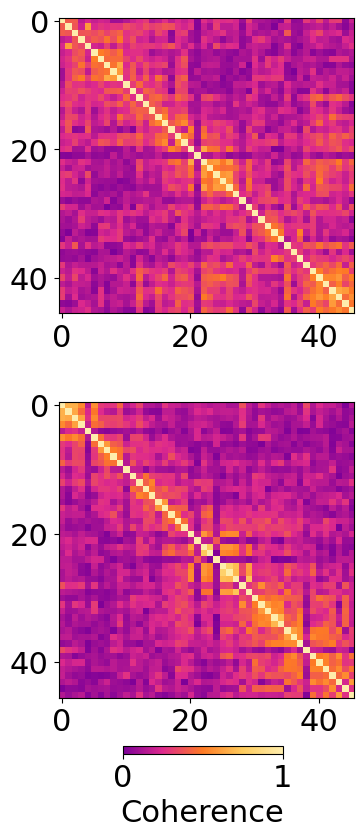

In [80]:
plt.rcParams["font.size"] = "22"
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax = axs[0]
im=ax.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[1]
ax.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)

cbar_ax2 = fig.add_axes([0.42, 0.03, 0.2, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')
fig.subplots_adjust(wspace=0.1, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.1)      

#plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare_coh_matrix.png', bbox_inches='tight', transparent=True, dpi=300)
